# Analyze Activation Space
## Imports

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import rasterio
from tqdm.auto import tqdm

from tlib import tgeo, tutils
from tjects.experiments.testbed18 import config, utils

%load_ext autoreload
%autoreload 2

In [2]:
asos = utils.load_asos()
files = [os.path.join(config.data_folder_tiles, file) for file in asos.map_ids]

## Get Land Cover Info of Vectors

In [3]:
# THIS CELL IS A COPY OF 32_analyze_activation_space

# get files and arrays
files_lcs = utils.get_corresponding_files(files, 'lcs')
lcs = np.stack([tgeo.geotif.get_array(file) for file in tqdm(files_lcs)])

# get channel names (from first files sample)
with rasterio.open(files_lcs[0]) as tif:
    lc_names = tif.descriptions
print(lc_names)

# vectorize
lc_vectors = asos.vectorize_same_way(maps=lcs)
lc_vectors = {lc_names[i]: lc_vectors[:, i] for i in range(len(lc_names))}
del lcs

# plot kwargs
lc_plot_kwargs = {}
for lc_name in lc_names:
    classes = tgeo.landcover.get_params(lc=lc_name)['classes']
    colors = tgeo.landcover.get_params(lc=lc_name)['colors']
    lc_plot_kwargs[lc_name] = {'color_discrete_map': {classes[i]: colors[i] for i in range(len(classes))}}

  0%|          | 0/4768 [00:00<?, ?it/s]

('CORINE', 'MODIS_1', 'CGLS', 'GlobCover')


## Assign Activation Map to Land Cover

In [4]:
# get group-lcs-matrix

lc_name = 'CORINE'

classes = tgeo.landcover.get_params(lc=lc_name)['classes']
groups_of_vectors = asos.predict_groups(asos.vectors)

group_lcs_matrix = np.zeros((asos.n_groups, len(classes)))
for i in tqdm(range(len(asos.vectors))):
    
    lc = lc_vectors[lc_name][i]
    if lc != 0:
        group_index = groups_of_vectors[i]
        lc_index = classes.index(lc)
        group_lcs_matrix[group_index, lc_index] += 1
        
n_vectors_in_groups = group_lcs_matrix.sum(axis=1)
group_lcs_matrix = group_lcs_matrix / n_vectors_in_groups.reshape(-1, 1)

group_lcs_matrix.shape

predicting groups:   0%|          | 0/981 [00:00<?, ?it/s]

  0%|          | 0/265558 [00:00<?, ?it/s]

(981, 44)

In [5]:
# get group-lc-assignment

threshold = 0.4

group_lc_percentage = group_lcs_matrix.max(1)

group_lc = group_lcs_matrix.argmax(1)
for i in range(len(group_lc)):
    if group_lc_percentage[i] > threshold:
        group_lc[i] = classes[group_lc[i]]
    else:
        group_lc[i] = -1

## Plot Samples        

In [6]:
# THIS CELL IS A COPY OF 34_analyze_samples

channel_indices = {'B2': 0, 'B3': 1, 'B4': 2, 'B5': 3, 'B6': 4, 'B7': 5, 'B8': 6, 'B8A': 7, 'B11': 8, 'B12': 9}

# files from dataset
datasets = ['test']

# get files from given dataset
fi = utils.load_file_infos()
df = fi.df
df = df[df['datasplit'].isin(datasets)]
print(f'# files: {len(df)}')
files = df.index


if config.dataset == 'anthroprotect':
    
    nearby_files_possible = True  # only if df is available
    plot_predictions = True  # only if df is available
    batch_size = 64
    
    s2_plotter = tgeo.s2.Plotter(
        folder_s2=config.data_folder_tiles,
        folder_lcs=utils.get_corresponding_folder(config.data_folder_tiles, 'lcs'),
        channel_indices=channel_indices,
    )

# files: 2404


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


predicting groups:   0%|          | 0/981 [00:00<?, ?it/s]

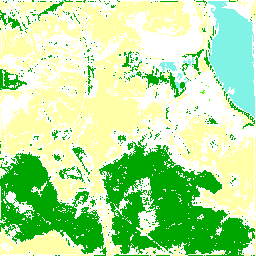

file: anthropo_16.87133-59.52749-22_75.tif
path:  /home/martin/Projekte/OGC_Testbed-18/data/anthroprotect/tiles/s2/anthropo_16.87133-59.52749-22_75.tif


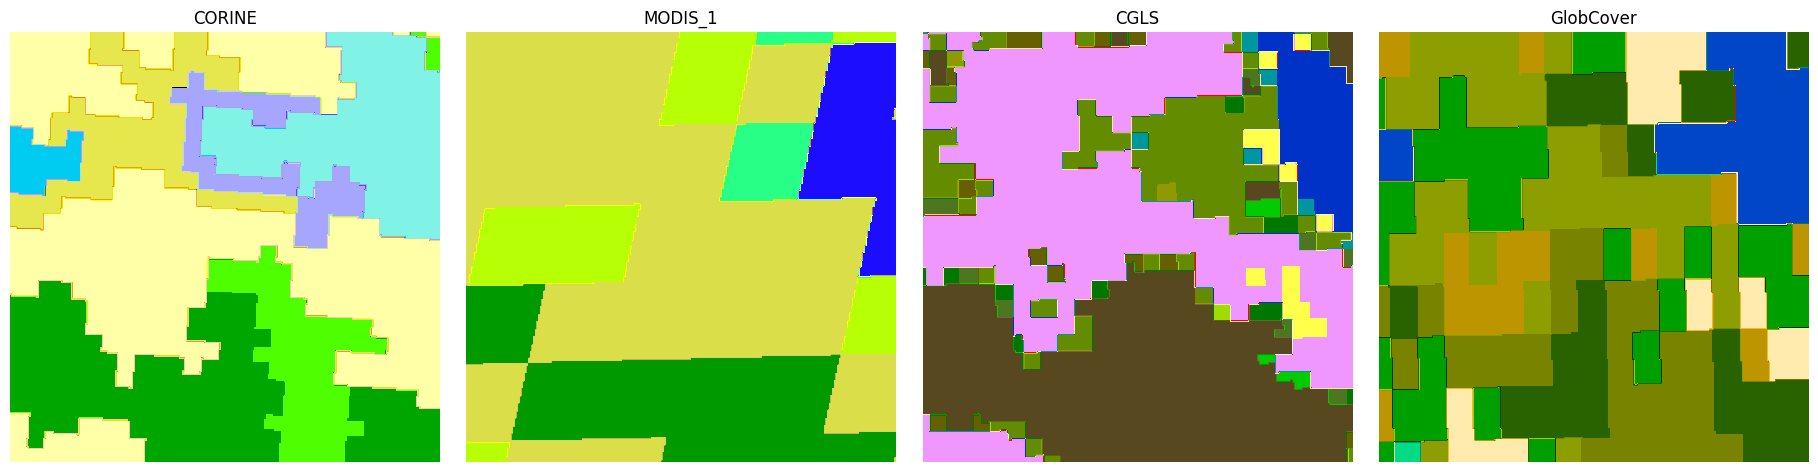

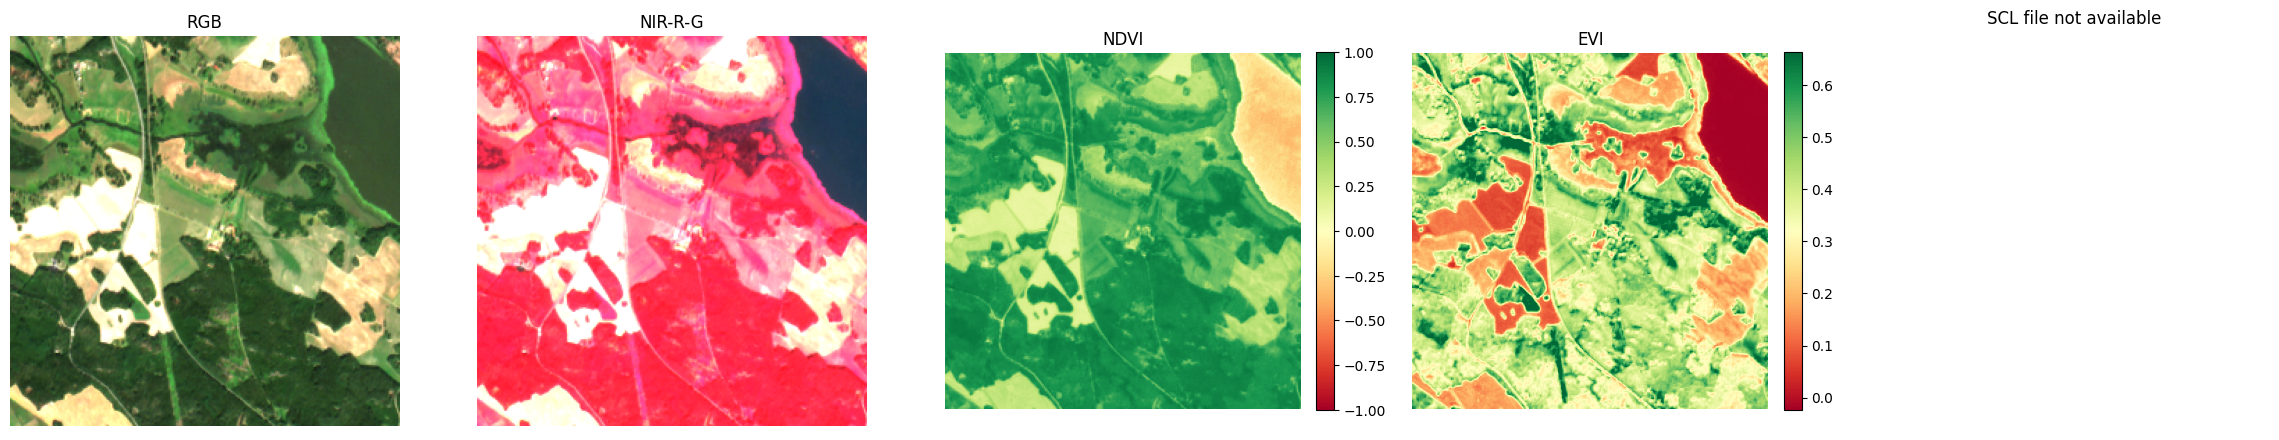

In [7]:
file = files[1100]

# predict lcs
activation_map = utils.predict_activation_maps(file)
groups_map = asos.predict_groups(activation_map)
lcs_map = np.zeros(groups_map.shape)
for i in range(groups_map.shape[1]):
    for j in range(groups_map.shape[2]):
        if groups_map[0][i][j] == -1:
            lcs_map[0][i][j] = -1
        else:
            group_index = groups_map[0][i][j]
            lcs_map[0][i][j] = group_lc[group_index]

            
# plot predicted lcs
params = tgeo.landcover.get_params(lc=lc_name)
colors, classes, framing_color = params['colors'], params['classes'], params['framing_color']
tutils.plots.plot_original_image_size(lcs_map[0], colors=colors, classes=classes, framing_color=framing_color)
plt.show()

# plot original file
s2_plotter.plot(file, plot_s2=True, plot_lcs=True)
plt.show()

## Correlation Matrix

In [8]:
import pandas as pd
df = pd.DataFrame({classes[i]: group_lcs_matrix[:, i] for i in range(len(classes))})
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

/home/martin/Projekte/OGC_Testbed-18/software/venv-testbed-18/lib/python3.8/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning:

All-NaN slice encountered

/home/martin/Projekte/OGC_Testbed-18/software/venv-testbed-18/lib/python3.8/site-packages/pandas/io/formats/style.py:3556: RuntimeWarning:

All-NaN slice encountered



,111,112,121,122,123,124,131,132,133,141,142,211,212,213,221,222,223,231,241,242,243,244,311,312,313,321,322,323,324,331,332,333,334,335,411,412,421,422,423,511,512,521,522,523
111,1.000000,-0.011670,0.207067,-0.005818,nan,-0.013039,0.059023,-0.007557,-0.004534,-0.014932,-0.020900,-0.055954,nan,nan,nan,-0.003690,nan,-0.027742,nan,-0.028157,-0.060055,nan,0.009087,-0.067979,-0.065324,0.143752,0.071842,nan,-0.056965,-0.001390,0.207482,0.205980,-0.002322,-0.004119,-0.022761,0.007107,-0.003435,nan,-0.001922,-0.015796,-0.017520,-0.003368,-0.003523,-0.010830
112,-0.011670,1.000000,0.163798,0.044973,nan,0.058724,0.010112,0.033026,-0.012081,0.088395,0.254480,0.519248,nan,nan,nan,0.005669,nan,0.131352,nan,0.277328,0.559536,nan,-0.158122,-0.220303,-0.035384,-0.063643,-0.271486,nan,0.205990,-0.031427,-0.133086,-0.150746,0.018684,-0.081725,0.066833,-0.261889,-0.025815,nan,0.020225,-0.102403,-0.172359,-0.018322,-0.039306,-0.063065
121,0.207067,0.163798,1.000000,0.037162,nan,0.092316,0.369946,0.292677,-0.023916,0.045569,0.069476,0.095330,nan,nan,nan,-0.014875,nan,-0.017837,nan,0.022334,-0.005625,nan,-0.056973,-0.197969,-0.167961,0.277115,0.001180,nan,0.081728,-0.001333,0.224330,0.369044,-0.011373,-0.034547,0.015391,-0.047441,-0.010790,nan,-0.010597,-0.009865,-0.096256,-0.000684,-0.019424,-0.053389
122,-0.005818,0.044973,0.037162,1.000000,nan,-0.020349,0.002249,0.054843,-0.007319,0.009410,0.011932,0.043407,nan,nan,nan,0.002026,nan,-0.000224,nan,0.139801,0.030724,nan,-0.023904,-0.037207,-0.024227,0.085112,-0.003408,nan,0.035106,-0.009221,0.051673,0.063832,-0.003731,-0.010710,-0.007164,-0.036382,-0.005595,nan,-0.003089,-0.025941,-0.034856,-0.005412,-0.005662,-0.017738
123,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
124,-0.013039,0.058724,0.092316,-0.020349,nan,1.000000,-0.012045,-0.001114,-0.014961,-0.034169,-0.012365,0.223823,nan,nan,nan,-0.008818,nan,0.068601,nan,-0.026907,0.015009,nan,-0.014501,-0.118618,-0.139063,-0.030160,-0.017210,nan,0.120834,0.008680,-0.027978,0.038704,-0.003535,-0.024211,0.103309,0.021814,-0.012570,nan,-0.006985,-0.041779,-0.070066,-0.009103,-0.012804,-0.038119
131,0.059023,0.010112,0.369946,0.002249,nan,-0.012045,1.000000,0.230599,0.082481,0.008313,0.001309,-0.036460,nan,nan,nan,-0.012083,nan,-0.024041,nan,-0.049276,-0.065294,nan,-0.005010,-0.143743,-0.135306,0.246991,0.055078,nan,-0.023917,-0.011128,0.335034,0.351733,-0.007432,-0.019399,-0.024634,-0.019203,-0.010646,nan,-0.006153,-0.021885,-0.051837,-0.010781,-0.011278,-0.031872
132,-0.007557,0.033026,0.292677,0.054843,nan,-0.001114,0.230599,1.000000,-0.009564,-0.017001,-0.033328,0.021429,nan,nan,nan,-0.005636,nan,-0.028028,nan,0.001173,-0.005562,nan,-0.020011,-0.089487,-0.073800,0.075733,0.023105,nan,0.019489,0.096724,0.165355,0.188364,0.061936,-0.014107,-0.028265,-0.026837,-0.007265,nan,0.010323,-0.026192,-0.044145,-0.007133,-0.007462,-0.022550
133,-0.004534,-0.012081,-0.023916,-0.007319,nan,-0.014961,0.082481,-0.009564,1.000000,0.001922,-0.017231,0.015537,nan,nan,nan,-0.003482,nan,-0.019947,nan,-0.012789,0.035455,nan,-0.043315,-0.024327,-0.015964,0.060571,0.006273,nan,-0.013285,-0.007219,0.023302,0.045034,-0.002921,-0.008383,-0.021500,-0.007680,-0.004276,nan,-0.002418,-0.020246,-0.004127,-0.004237,-0.004432,-0.013857
141,-0.014932,0.088395,0.045569,0.009410,nan,-0.034169,0.008313,-0.017001,0.001922,1.000000,0.073665,0.058543,nan,nan,nan,-0.007604,nan,-0.007045,nan,0.244951,0.170884,nan,-0.005298,0.038155,0.055457,-0.065325,-0.099092,nan,0.025173,-0.023790,-0.068170,-0.096258,0.045599,-0.027625,0.041897,-0.107075,0.003863,nan,0.015812,0.009460,-0.051721,0.000195,-0.014336,-0.044139
